In [1]:

from google.colab import files
from google.colab import drive

files.upload()

#! pip install -q kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                            7KB  2022-06-15 08:59:12           5976        201  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)      6MB  2022-06-22 12:51:18           1852         84  1.0              
victorsoeiro/netflix-tv-shows-and-movies                  Netflix TV Shows and Movies                          2MB  2022-05-15 00:01:23          16508        479  1.0              
sameepvani/nasa-nearest-earth-obje

In [2]:
! kaggle datasets download -d kaushiksuresh147/bitcoin-tweets
#! kaggle datasets download -d mczielinski/bitcoin-historical-data

 99% 565M/568M [00:03<00:00, 186MB/s]
100% 568M/568M [00:03<00:00, 161MB/s]


In [3]:
! ls

bitcoin-tweets.zip  sample_data


In [5]:
! unzip bitcoin-tweets.zip

Archive:  bitcoin-tweets.zip
  inflating: Bitcoin_tweets.csv      


In [6]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **EDA**

In [7]:
df = pd.read_csv('Bitcoin_tweets.csv')

In [8]:
#df.shape #(3840626 rows, 13 columns)
!rm Bitcoin_tweets.csv, bitcoin-tweets.zip, bitcoin-historical-data.zip, sample_data # to free up RAM
df.head()

rm: cannot remove 'Bitcoin_tweets.csv,': No such file or directory
rm: cannot remove 'bitcoin-tweets.zip,': No such file or directory
rm: cannot remove 'bitcoin-historical-data.zip,': No such file or directory
rm: cannot remove 'sample_data': Is a directory


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [9]:
#df.describe
df.isna().sum()
# 182 rows with NaN values, safe to drop considering df size

user_name                40
user_location       1967398
user_description     465769
user_created            108
user_followers          162
user_friends            162
user_favourites         162
user_verified           162
date                    162
text                    162
hashtags              17244
source                 3815
is_retweet              502
dtype: int64

In [10]:
df = df.dropna(subset=['text', 'date']) #dropping missing values for text and date
df.isna().sum() 

user_name                40
user_location       1967290
user_description     465662
user_created              0
user_followers            0
user_friends              0
user_favourites           0
user_verified             0
date                      0
text                      0
hashtags              17082
source                 3653
is_retweet              340
dtype: int64

In [11]:
df["text_length"] = df["text"].str.len()
df["text"] = df["text"].str.lower()

In [12]:
counts = df.groupby(['source'])['source'].count().reset_index(name='counts').sort_values(by='counts', ascending=False)
counts[0:10] #we probably should keep legitimate sources to eliminate the possibility of bots

#potential sources to keep: Twitter for Android, Twitter Web App, Twitter for iPhone, Twitter for iPad

,source,counts
1760,Twitter for Android,1154598
1752,Twitter Web App,1021234
1766,Twitter for iPhone,755617
883,IFTTT,56375
2099,dlvr.it,39512
1699,TweetDeck,29530
2505,vaiotapi,24190
1765,Twitter for iPad,23647
452,ContentStudio.io,23420
1072,Microsoft Power Platform,20578


In [13]:
df= df[(df['source'] == 'Twitter for iPad') | (df['source'] == 'Twitter for iPhone') | 
          (df['source'] == 'Twitter for Android') | (df['source'] == 'Twitter Web App')]

In [14]:
df['tweet_yyyymmdd'] = pd.to_datetime(df['date']).dt.date
#df['month'] = df['tweet_yyyymmdd'].dt.month
#df['year'] = df['tweet_yyyymmdd'].dt.year

In [15]:
print(df['tweet_yyyymmdd'].min())
print(df['tweet_yyyymmdd'].max())

2021-02-05
2022-07-09


<Figure size 1080x288 with 0 Axes>

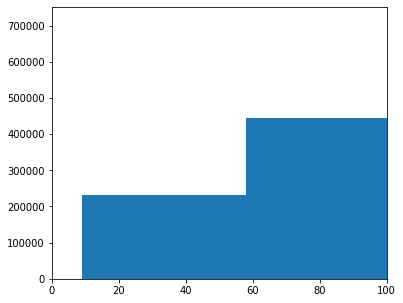

In [ ]:
plt.figure().set_figwidth(15)
plt.figure().set_figheight(5)

plt.hist(df['text_length'],bins=20)
plt.xlim(0,100)
plt.show() 
#there appears to be a 8 char minimum in a tweet, we probably dont have to filter out minimal/no effort tweets

In [ ]:
#@title
def clean_tweets (tweet):
  '''
  func: 
    Convert tweets to lower case
    Replace URLs with a space in the message
    Replace ticker symbols with space. The ticker symbols are any stock symbol that starts with $
    Replace usernames with space, the usernames are any word that starts with @
    Replace everything not a letter or apostrophe with space
    Remove single letter words
    Use root words (lemmatize, e.g., buying vs buy), remove stop words, filter all the non-alphabetic words
  '''  
  tweet = tweet.lower
  tweet = re.sub('https?:\/\/la-zA-20-90:8. \/+~#=?6;-1*', ' ', tweet)
  tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
  tweet = re.sub('\@[a-zA-z0-9]*', ' ', tweet)
  tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
  tweet = ' '.join( [i for i in tweet.split() if len(i)>1])
  #tweet = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) if x not in stop_words])
  #tweet = [lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(tweet) if x not in stop_words]
  return tweet
  ``

In [ ]:
#@title
#Taking a copy of our original DataFrame to test out cleaning the data
test1=df.copy()

# uniform the data by converting all the data to lower case because Python is a case-sensitive language
test1['text']=test1['text'].str.lower()

AttributeError: ignored

In [ ]:
#initializing Lemmatizer and stopwords
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [ ]:
def clean_tweet(text):
    '''           
    func: 
          Replace ticker symbols with space. The ticker symbols are any stock symbol that starts with $.
          Replace  usernames with space. The usernames are any word that starts with @.
          Replace everything not a letter or apostrophe with space
          Remove single letter words
          lemmatize, tokenize (nouns and verb), remove stop words, filter all the non-alphabetic words, then join
          them again

    '''

    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    text = re.sub('[^a-zA-Z\']', ' ', text)
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    text=' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in stop_words])
    text=[lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in stop_words]
    return text 

In [ ]:
# define a function to clean the Hashtags.
def clean_hashtags(hashtags):
    '''

    func: Convert hashtags to lower case
          Replace ticker symbols with space. The ticker symbols are any stock symbol that starts with $.
          Replace everything not a letter or apostrophe with space
          Removes any spaces or specified characters at the start and end of hashtags.
          
    '''
    if hashtags:
        hashtags = hashtags.lower()
        hashtags = re.sub('\$[a-zA-Z0-9]*', ' ', hashtags)
        hashtags = re.sub('[^a-zA-Z]', ' ', hashtags)
        hashtags=hashtags.strip() 
    return hashtags

In [ ]:
# clean the tweets and create two columns: tokenized tweet and whole tweet
# this takes ~15 minutes to run, so grab a snack
df['clean_tweet']=df['text'].apply(lambda x:clean_tweet(x))
df['cleaned_tweet']=df['clean_tweet'].apply(lambda x:' '.join(x))

In [ ]:
# clean the hashtags
df['hashtags']=df['hashtags'].astype(str)
df['hashtags']=df['hashtags'].apply(lambda x:clean_hashtags(x))

In [ ]:
df[0:50]

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,text_length,tweet_yyyymmdd,clean_tweet,cleaned_tweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,blue ridge bank shares halted by nyse after #b...,bitcoin,Twitter Web App,False,135,2021-02-10,"[blue, ridge, bank, share, halt, nyse, bitcoin...",blue ridge bank share halt nyse bitcoin atm an...
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 today, that's this #thursday, we will do a ""...",thursday btc wallet security,Twitter for Android,False,140,2021-02-10,"[today, ', thursday, take, friend, btc, wallet...",today ' thursday take friend btc wallet securi...
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"guys evening, i have read this article about b...",nan,Twitter Web App,False,136,2021-02-10,"[guy, even, read, article, btc, would, like, s...",guy even read article btc would like share
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,this network is secured by 9 508 nodes as of t...,btc,Twitter Web App,False,140,2021-02-10,"[network, secure, node, today, soon, biggest, ...",network secure node today soon biggest bear re...
5,ZerrBenz™ ⚔ ✪ 20732,"Bkk, Thailand",I'm a cat slave 🐱 Interested in Blockchain · T...,2010-01-12 07:00:04,742.0,716,2444,False,2021-02-10 23:53:30,💹 trade #crypto on #binance \n\n📌 enjoy #cashb...,crypto binance cashback,Twitter Web App,False,136,2021-02-10,"[trade, crypto, binance, enjoy, cashback, trad...",trade crypto binance enjoy cashback trade fee ...
8,Mikcoin,NaN,"Technical Analyst | Trader\n\nNo certainty, on...",2020-11-26 23:45:46,104.0,41,238,False,2021-02-10 23:52:25,#btc #bitcoin #ethereum #eth #crypto #cryptotr...,btc bitcoin ethereum eth crypto ...,Twitter Web App,False,139,2021-02-10,"[btc, bitcoin, ethereum, eth, crypto, cryptotr...",btc bitcoin ethereum eth crypto cryptotrading ...
9,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:52:08,.@tesla’s #bitcoin investment is revolutionary...,bitcoin crypto,Twitter Web App,False,140,2021-02-10,"[bitcoin, investment, revolutionary, crypto, f...",bitcoin investment revolutionary crypto firm m...
10,@massumeh18 #RefinedWarrior #Activist,NOVA,Persistent. to the extreme... #FREEPALESTINE #...,2009-01-05 13:28:47,1159.0,2185,30852,False,2021-02-10 23:52:04,annnd #btc #bitcoin is headed even higher now....,btc bitcoin,Twitter Web App,False,72,2021-02-10,"[annnd, btc, bitcoin, head, even, higher]",annnd btc bitcoin head even higher
12,CPUcoin,Cayman Islands,The Sharing Economy for CPU/GPU Power. Revolut...,2018-08-27 15:42:00,5097.0,791,52,False,2021-02-10 23:50:59,join our first virtual crypto meetup of 2021 -...,nan,Twitter Web App,False,139,2021-02-10,"[join, first, virtual, crypto, meetup, crypto,...",join first virtual crypto meetup crypto friday...
13,One Perspective,Market Place,It's all a market of markets.\n\nPast performa...,2018-01-09 21:49:45,668.0,1097,6853,False,2021-02-10 23:50:30,#bitcoin #btc $btc $gbtc $riot $mara $eth $eth...,bitcoin btc aave defi crypto cr...,Twitter for Android,False,135,2021-02-10,"[bitcoin, btc, aave, defi, crypto, cryptocurre...",bitcoin btc aave defi crypto cryptocurrency


In [ ]:
# export tweet data

df.to_csv('tweets_cleaned.csv')

drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/bitcoin_price_prediction/tweets_cleaned.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Mounted at /content/drive
